# Klett e Raman - Processamento
Exemplo de processamento de sinal lidar com algoritmo Klett e Raman.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from atmospheric_lidar import licelv2
import glob
import os
#from atmospheric_lidar.licel import LicelLidarMeasurement
from lifa.licel import LicelLidarMeasurement
import lifa.processing.helper_functions as hp
import lifa.processing.pre_processing as pre
import lifa.processing.elastic_retrievals as ela
import lifa.processing.raman_retrievals as ram
import lifa.processing.helper_functions as hp
import math
import pandas as pd

## Importa dados de referencia
Temos dados da raymetrics (apenas elástico) e obtidos no IPEN (elástico e raman em N2)

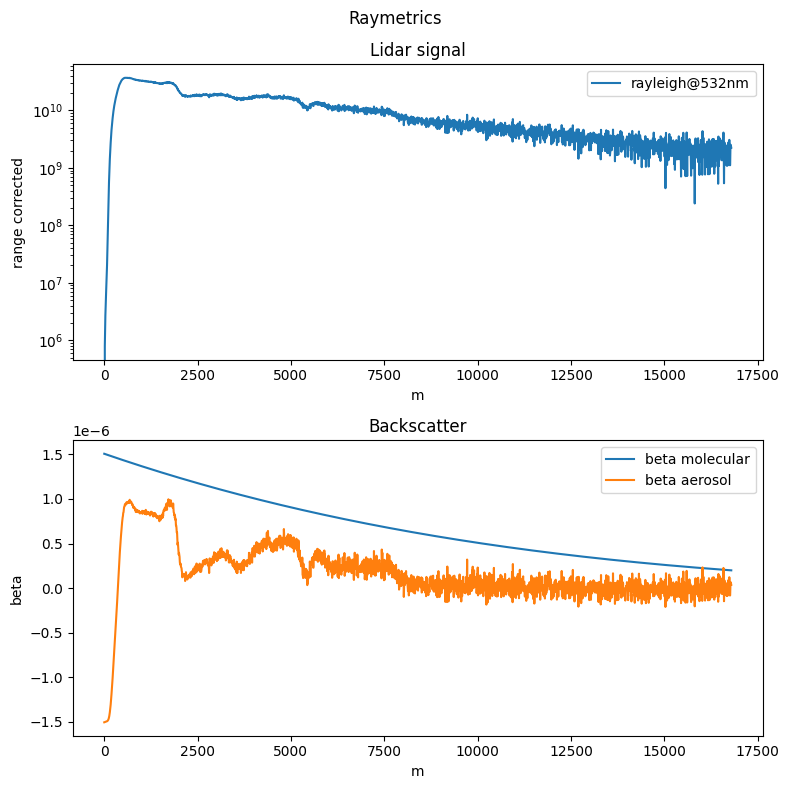

In [2]:
# Dados exemplo raymetrics
ref_data = pd.read_csv('./sample_data/klett/rc532_20160406_0029_0229.txt', delimiter='\t')

raymetrics = {}
raymetrics['z'] = ref_data['Altitude(m)'].to_numpy()
raymetrics['rayleigh_rc'] =  ref_data['Range Corrected Signal(m^-1 sr^-1)'].to_numpy()
raymetrics['rayleigh_lambda'] = 532

# Estes valores vieram da unidade de testes no codigo da Raymetrics
raymetrics['lidar_ratio'] = 50
raymetrics['index_reference'] = 1338    #1338*7,5=10.035 m
raymetrics['reference_range'] = 134     #134*7,5=1005 m 
raymetrics['beta_aerosol_reference'] = 3E-8
raymetrics['bin_width'] = 7.5

# Dados calculados por klett
ref_klett_data = pd.read_csv('./sample_data/klett/b532_20160406_0029_0229.txt', delimiter='\t')
raymetrics['molecular_backscatter'] = ref_klett_data['beta_molecular(m^-1 sr^-1)'].to_numpy()
raymetrics['aerosol_backscatter'] = ref_klett_data['beta_aerosol(m^-1 sr^-1)'].to_numpy()

# Apresenta grafico dos dados
plt.figure(figsize=(8,8))
plt.suptitle('Raymetrics')
plt.subplot(2,1,1)
plt.plot(raymetrics['z'], raymetrics['rayleigh_rc'], label='rayleigh@{}nm'.format(raymetrics['rayleigh_lambda']) )
plt.title('Lidar signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('range corrected')
plt.xlabel('m')

plt.subplot(2,1,2)
plt.plot(raymetrics['z'], raymetrics['molecular_backscatter'], label='beta molecular') 
plt.plot(raymetrics['z'], raymetrics['aerosol_backscatter'], label='beta aerosol') 

#plt.plot(lidar_data['z'], lidar_data['raman_rc'], label='raman@{}nm'.format(lidar_data['raman_lambda']))
plt.title('Backscatter')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta')
plt.xlabel('m')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()


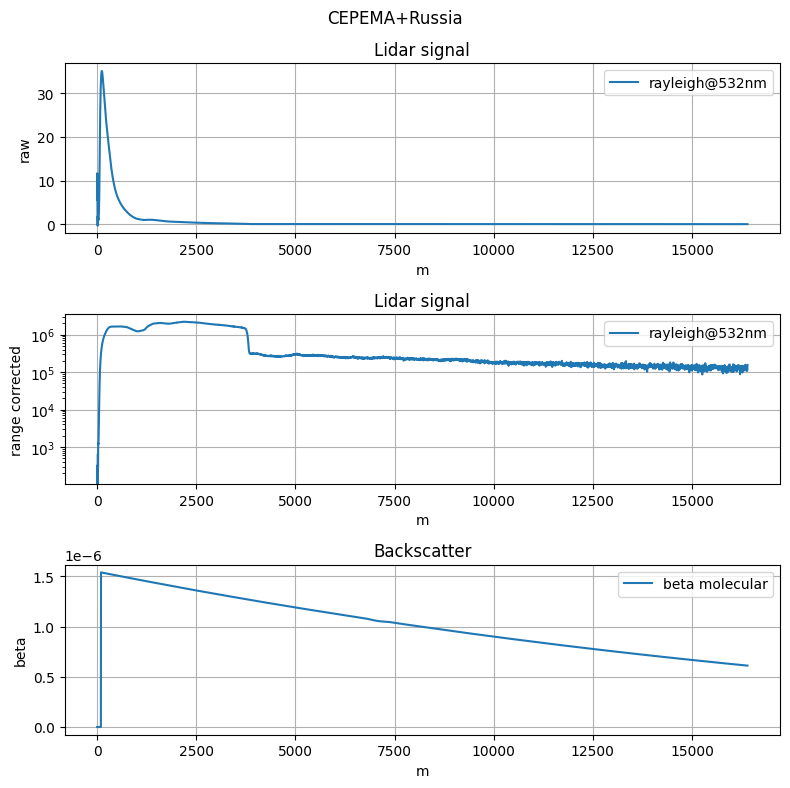

In [3]:
# Dados exemplo programa russos
rus_data = pd.read_csv('./sample_data/raman/signal.txt', delimiter='\t')

# subset
rus_data = rus_data[:-12000]

russia = {}
russia['z'] = rus_data['H'].to_numpy()
russia['rayleigh'] = rus_data['532_Anlg'].to_numpy()
russia['rayleigh_lambda'] = 532
russia['raman'] = rus_data['530_Anlg'].to_numpy()
russia['raman_lambda'] = 530
russia['molecular'] = rus_data['532_Anlg_Molec'].to_numpy()
russia['molecular_backscatter'] = rus_data['MolecBack532_Anlg'].to_numpy()
russia['molecular_extinction'] = rus_data['MolecExt532_Anlg'].to_numpy()
russia['elevation_angle'] = 32

# background subtraction
# Background foi retirado no sinal antes de exportar os dados do programa russo. Está aqui somente como exemplo
min_bg = -1000
max_bg = -1
russia['rayleigh_bgc'], rayleigh_bg_mean, rayleigh_bg_std = pre.subtract_background(russia['rayleigh'], min_bg, max_bg)
russia['raman_bgc'], raman_bg_mean, raman_bg_std = pre.subtract_background(russia['raman'], min_bg, max_bg)

# Aplica Range correction no sinal com background ja removido
russia['rayleigh_rc'] = pre.apply_range_correction(russia['rayleigh'], russia['z'])
russia['raman_rc'] = pre.apply_range_correction(russia['raman'], russia['z'])


# Lidar ratio é a divisão entre o coeficiente alfa de extinsão e beta de backscattering. Depende da particula. Para 532nm ~50
russia['lidar_ratio'] = 50
# Pixel onde inicia a região de referencia para klett, onde não deve existir mais espalhamento por aerosol
russia['index_reference'], russia['reference_range'] = hp.meters_to_bins(10000, 500, russia['z'])
# Valor do beta para aerosol na região de referencia. Idealmente é zero, pois é desejado que a região de referencia tenha somente resposta molecular
russia['beta_aerosol_reference'] = 0E-8
russia['bin_width'] = 3.75


# Resultados klett obtidos com software russo
russia_klett = pd.read_csv('./sample_data/raman/c532_Klett 532_.txt', delimiter='\t')
russia['z_klett'] = russia_klett['H'].to_numpy()
russia['klett_extinction'] = russia_klett['Ext'].to_numpy()
russia['klett_backscatter'] = russia_klett['Back'].to_numpy()
russia['klett_lidar_ratio'] = russia_klett['LR'].to_numpy()

# Resultados Raman obtidos com software russo
russia_raman = pd.read_csv('./sample_data/raman/c532_Raman 532_.txt', delimiter='\t')
russia['z_raman'] = russia_raman['H'].to_numpy()
russia['raman_extinction'] = russia_raman['Ext'].to_numpy()
russia['raman_backscatter'] = russia_raman['Back'].to_numpy()
russia['raman_lidar_ratio'] = russia_raman['LR'].to_numpy()


# Dados de entrada
plt.figure(figsize=(8,8))
plt.suptitle('CEPEMA+Russia')
plt.subplot(3,1,1)
plt.plot(russia['z'], russia['rayleigh'], label='rayleigh@{}nm'.format(raymetrics['rayleigh_lambda']) )
plt.title('Lidar signal')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('raw')
plt.xlabel('m')
plt.grid(True)


plt.subplot(3,1,2)
plt.plot(russia['z'], russia['rayleigh_rc'], label='rayleigh@{}nm'.format(raymetrics['rayleigh_lambda']) )
plt.title('Lidar signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('range corrected')
plt.xlabel('m')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(russia['z'], russia['molecular_backscatter'], label='beta molecular') 
#plt.plot(raymetrics['z'], raymetrics['aerosol_backscatter'], label='beta aerosol') 
#plt.plot(lidar_data['z'], lidar_data['raman_rc'], label='raman@{}nm'.format(lidar_data['raman_lambda']))
plt.title('Backscatter')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta')
plt.xlabel('m')
plt.grid(True)

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()



In [4]:
# Atribui dados as serem processados
lidar_data = russia
#lidar_data = raymetrics

## Klett
No processamento Klett o sinal elástico é utilizado para calculo do extinction e backscattering ratio. Um paramentro importante para isso é o lidar ratio, que é a relação entre esses dois parametros. Esse valor varia com distancia e particulas, por isso o processamento pro klett é uma aproximação, e o lidar ratio é mantido constante. Para 532 nm o valor de lidar ratio é por volta de 50. 
No processamento Klett é necessário definir uma região onde esperasse encontrar apenas espalhamento molecular (sem aerosol). O espalhamento molecular pode ser calculado teoricamento a partir de pressão e temperatura do ar. 

In [5]:
backscatter_output = ela.klett_backscatter_aerosol(range_corrected_signal=lidar_data['rayleigh_rc'],        #Sinal rayleigh com range correction
                                                       lidar_ratio_aerosol=lidar_data['lidar_ratio'],       #Fator lidar ratio
                                                       beta_molecular=lidar_data['molecular_backscatter'],  #Curva molecular beta utilizada com referencia    
                                                       index_reference=lidar_data['index_reference'],       #Indice acima do qual é esperado ter somente espalhamento molecular
                                                       reference_range=lidar_data['reference_range'],       #Faixa na referencia onde é feita média
                                                       beta_aerosol_reference=lidar_data['beta_aerosol_reference'], #Valor de beta aerosol na referencia, geralmente zero se não houver aerossol
                                                       bin_length=lidar_data['bin_width'])  # tamanho do bin na medida

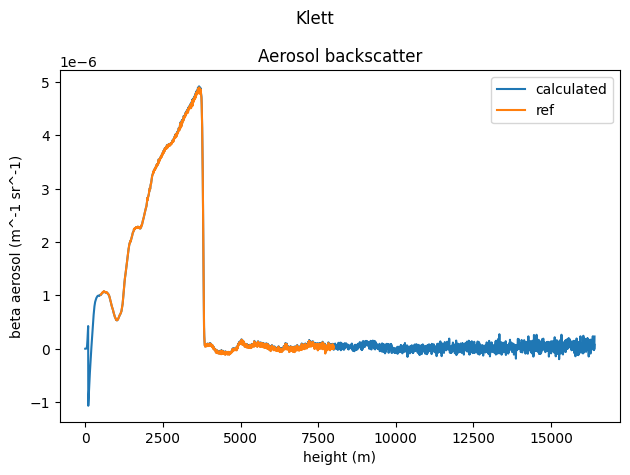

In [6]:
plt.subplot(1,1,1)
plt.suptitle('Klett')
plt.plot(lidar_data['z'], backscatter_output, label='calculated')
plt.plot(lidar_data['z_klett'], lidar_data['klett_backscatter'], label='ref')
plt.title('Aerosol backscatter')
plt.legend(loc='upper right')
plt.ylabel('beta aerosol (m^-1 sr^-1)')
plt.xlabel('height (m)')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

## Raman
No processamento Raman, dois sinais são utilizados, o Rayleigh e o Raman. Neste caso não é necessário estimar o lidar ratio, ele é obtido através dos cálculos. Primeiramente o extinction rate é obtido a partir do sinal Raman, geralmente do N2. A ideia é a seguinte: supondo distribuição homogênea de N2 na atmosfera, é conhecido o espalhamento molecular teorico dele. Comparando o sinal teórico com obtido na medida Raman é possível determinar o fator de extinção do elástico. Isso depois é utilizado para calcular o fator de espalhamento para o aerosol. Portanto o resultado desse algoritmo é o fator de extinção e espalhamento para o canal elástico, o sinal raman é utilizado com referencia.

In [7]:
# Gera "pressao" e "temperatura" as partir do backscatter de aerosol dos russos
# Os dados exportados dos russos só vem com o beta molecular, e não com temperatura e pressão
# que são necessários para esse algoritmo. Aqui é feita uma sacanagem para calcular
# valores de pressão e temperatura a partir dos dados dos russos para facilitar comparação.
# Os dados não são reais e nem fazem sentido, pois é assumido que a temperatura é sempre 1. Mas
# o beta molecular calculados a partir destes números são os mesmos dos russos. Isso facilita comparação
# dos resultados
pressure = lidar_data['molecular_backscatter']/hp.f_bst(lidar_data['rayleigh_lambda'])*100
temperature = pressure/pressure

# Calcula extinction rate para aerosol a partir de sinal Raman
alpha_aer = ram.raman_extinction(lidar_data['raman_rc'],    # array sinal raman com range correction
                                 lidar_data['bin_width'],   # tamanho de cada bin em metros
                                 lidar_data['rayleigh_lambda'], # comprimento de onda do laser/rayleigh
                                 lidar_data['raman_lambda'],    # comprimento de onda sinal raman
                                 angstrom_aerosol=1,    # fator de relação. Geralmente por volta de 1
                                 temperature=temperature,   # array com temperatura do ar
                                 pressure=pressure,     # array com pressão do ar
                                 window_size=5,     # deve ser algum tipo de janela para filtro
                                 order = 4)         # ordem de algum tipo de filtro

# Calcula backscatter para aerosol
backscatter_aer = ram.raman_backscatter(lidar_data['raman_rc'],     #sinal raman range corrected
                                        lidar_data['rayleigh_rc'],  #sinal rayleigh range corrected
                                        lidar_data['bin_width'],    # tamanho bin em metros
                                        lidar_data['index_reference'],  #indice para referencia, onde começa somente espalhamento molecular
                                        alpha_aer,                      #extinction rate para aerosol calculado anteriormente a partir do sinal Raman
                                        1,                              # fator angstrom
                                        lidar_data['rayleigh_lambda'],  # comprimento de onda rayleigh
                                        lidar_data['raman_lambda'],     # comprimento de onda raman
                                        pressure,                       # array pressao
                                        temperature,                    # array temperatura
                                        lidar_data['beta_aerosol_reference'],   # valor de beta aerosol no ponto de referencia (geralmente zero)
                                        lidar_data['reference_range'])          # faixa onde é calculada a referencia

C:\Users\jairo\AppData\Local\Temp\ipykernel_13800\1634302544.py:9: RuntimeWarning: invalid value encountered in divide
  temperature = pressure/pressure


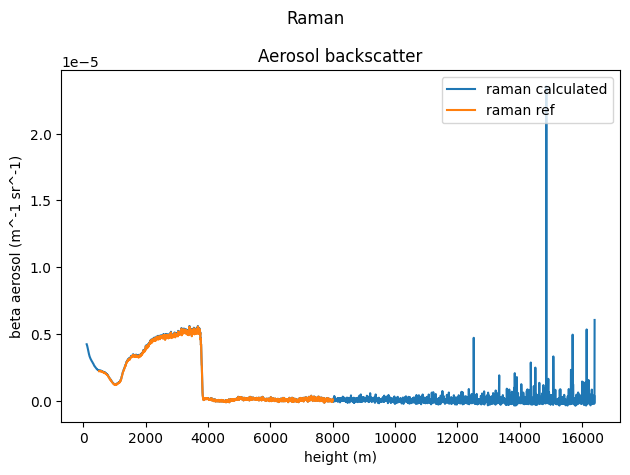

In [8]:
plt.subplot(1,1,1)
plt.suptitle('Raman')
plt.plot(lidar_data['z'], backscatter_aer, label='raman calculated')
plt.plot(lidar_data['z_raman'], lidar_data['raman_backscatter'], label='raman ref')

#plt.plot(lidar_data['z'], backscatter_output, label='klett calculated')
#plt.plot(lidar_data['z_klett'], lidar_data['klett_backscatter'], label='klett ref')

plt.title('Aerosol backscatter')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta aerosol (m^-1 sr^-1)')
plt.xlabel('height (m)')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

### Klett + Raman
É esperado que a curva de backscattering obtida pelo Klett e Raman sejam similares. O Raman deve fornecer uma curva mais precisa com alterações do lidar ratio, embora mais ruidosa, já que o sinal raman é mais ruidoso.

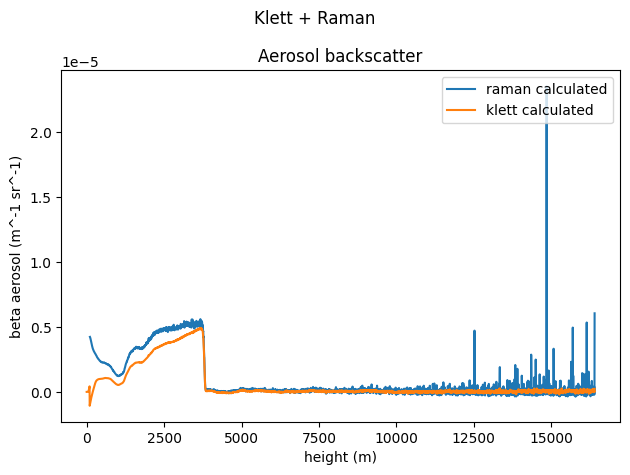

In [9]:
plt.subplot(1,1,1)
plt.suptitle('Klett + Raman')
plt.plot(lidar_data['z'], backscatter_aer, label='raman calculated')
#plt.plot(lidar_data['z_raman'], lidar_data['raman_backscatter'], label='raman ref')

plt.plot(lidar_data['z'], backscatter_output, label='klett calculated')
#plt.plot(lidar_data['z_klett'], lidar_data['klett_backscatter'], label='klett ref')

plt.title('Aerosol backscatter')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta aerosol (m^-1 sr^-1)')
plt.xlabel('height (m)')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

# Em desenvolvimento daqui pra baixo....
TODO:
- Verificação de beta molecular da atmosfera com 
- Atmosfera padrão
- Angulo de emissão
- ETC

## Atmosfera

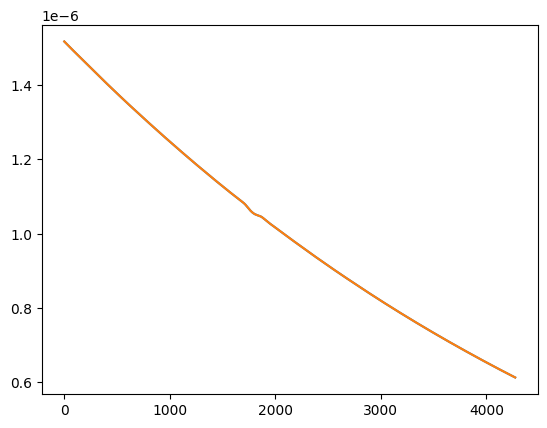

In [ ]:
elevation_angle = 90
elevation = 0
height = lidar_data['z'] * math.sin(math.radians(elevation_angle)) + elevation 

# Modelo Padrão
pressure, temperature, density = hp.standard_atmosphere(height)

plt.plot(lidar_data['molecular_backscatter'][100:])

pressure2 = lidar_data['molecular_backscatter']/hp.f_bst(lidar_data['rayleigh_lambda'])*100
temperature2 = pressure/pressure

plt.plot(hp.molecular_backscatter(532, pressure2, temperature2)[100:])

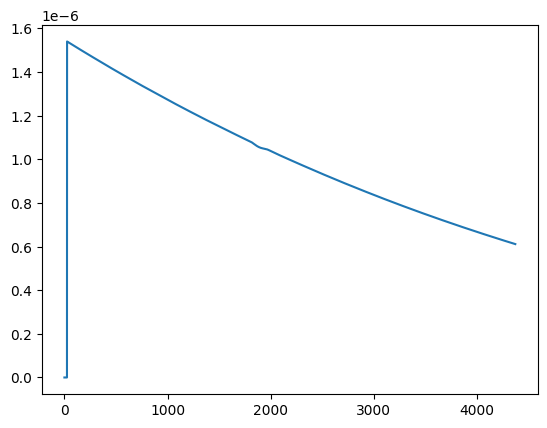

In [70]:
plt.plot(pressure2/temperature2)

In [26]:
len(lidar_data['raman_rc'][10:])

4364

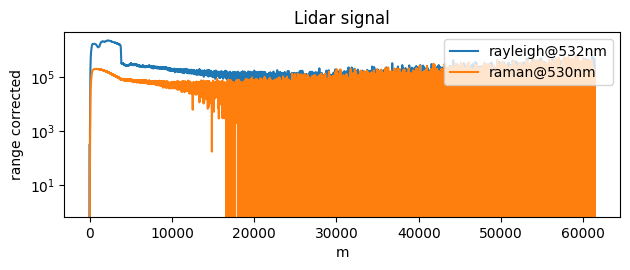

In [15]:
# Dados de entrada
plt.subplot(2,1,1)
plt.plot(lidar_data['z'], lidar_data['rayleigh_rc'], label='rayleigh@{}nm'.format(lidar_data['rayleigh_lambda']) )
plt.plot(lidar_data['z'], lidar_data['raman_rc'], label='raman@{}nm'.format(lidar_data['raman_lambda']))
plt.title('Lidar signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('range corrected')
plt.xlabel('m')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

## Klett

In [ ]:
# Apresenta dad
plt.subplot(2,1,1)
plt.plot(ref['z'], ref['rayleigh_signal'], label='rayleigh')
plt.title('Lidar signal')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('range corrected')
plt.xlabel('m')

plt.subplot(2,1,2)
plt.plot(ref['z'], ref_klett['molecular'], label='beta molecular')
plt.title('Molecular')
plt.legend(loc='upper right')
#plt.ylabel('')
plt.xlabel('m')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

NameError: name 'ref_klett' is not defined

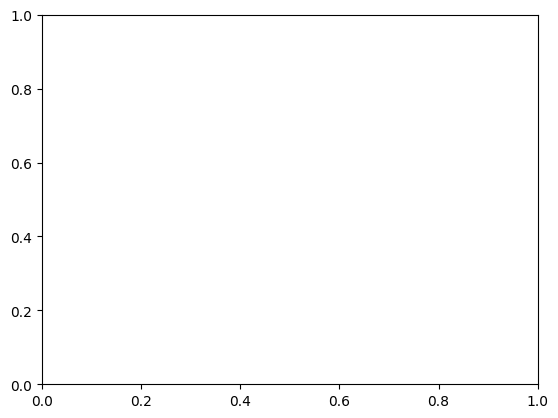

In [33]:
plt.subplot(1,1,1)
plt.plot(ref_klett['z'], ref_klett['backscatter'], label='ref')
plt.plot(ref_klett['z'], backscatter_output, label='calculated')
plt.title('Lidar signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta aerosol (m^-1 sr^-1)')
plt.xlabel('height (m)')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

### Temperatura e pressão atmosfera


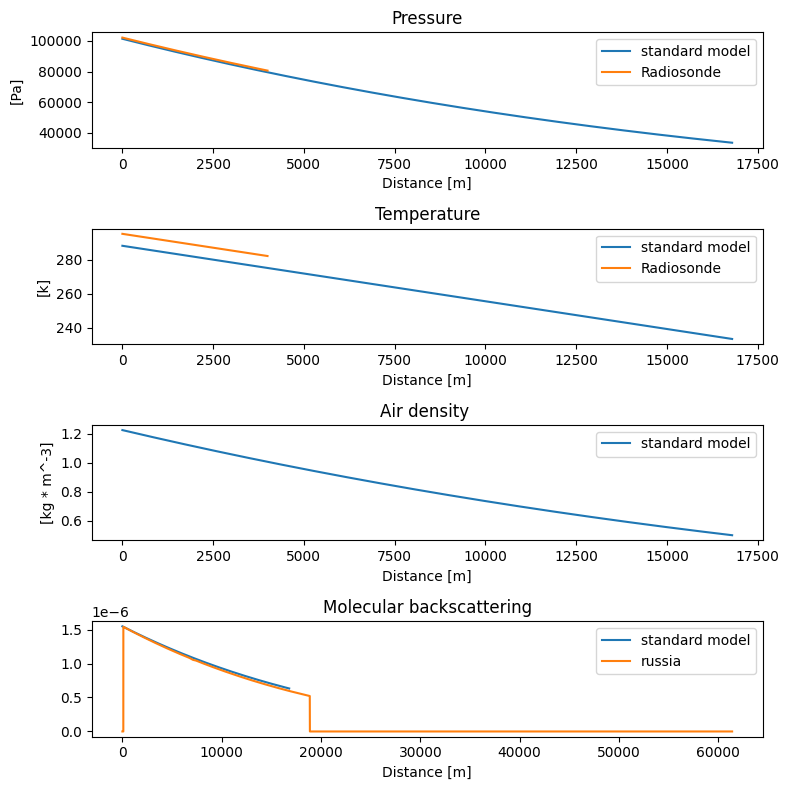

In [15]:
import lifa.processing.helper_functions as hp
import math

elevation_angle = 30
elevation = 0
wavelength = 532
z = ref['z']
height = z * math.sin(math.radians(elevation_angle)) + elevation 

# Modelo Padrão
pressure, temperature, density = hp.standard_atmosphere(height)
molecular_backscatter = hp.molecular_backscatter(wavelength, pressure, temperature)

# Radiosonda
sonde_data = ref_klett_data = pd.read_csv('./sample_data/klett/press_and_temp.csv', delimiter=',')
z_sonde = sonde_data['z_m'].to_numpy()/math.sin(math.radians(elevation_angle)) - elevation
pressure_sonde = sonde_data['p_Pa'].to_numpy()
temperature_sonde = sonde_data['T_K'].to_numpy()



plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(z, pressure, label='standard model')
plt.plot(z_sonde, pressure_sonde, label='Radiosonde')
plt.ylabel('[Pa]')
plt.title('Pressure')
plt.xlabel('Distance [m]')
plt.legend(loc='upper right')

plt.subplot(4,1,2)
plt.plot(z, temperature, label='standard model')
plt.plot(z_sonde, temperature_sonde, label='Radiosonde')
plt.title('Temperature')
plt.ylabel('[k]')
plt.xlabel('Distance [m]')
plt.legend(loc='upper right')

plt.subplot(4,1,3)
plt.plot(z, density, label='standard model')
plt.title('Air density ')
plt.ylabel('[kg * m^-3]')
plt.xlabel('Distance [m]')
plt.legend(loc='upper right')

plt.subplot(4,1,4)
plt.plot(z, molecular_backscatter, label='standard model')
plt.plot(rus_z, rus_bk_molecular, label='russia')
plt.title('Molecular backscattering')
#plt.ylabel('[kg * m^-3]')
plt.xlabel('Distance [m]')
plt.legend(loc='upper right')



plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

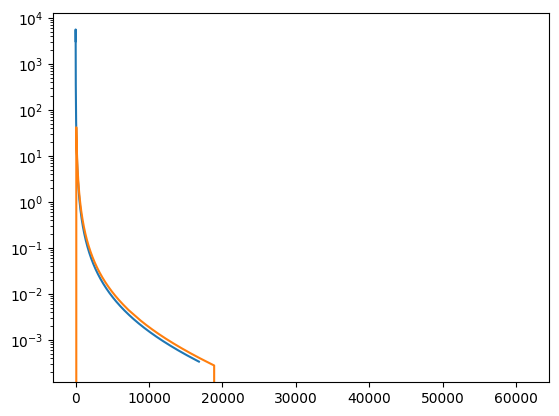

In [16]:
#Calcula sinal Lidar a partir somente do sinal molecular
# P(R) = k/R^2 O(R) B(R) exp (-2Integral(A(R)))

from scipy.integrate import cumulative_trapezoid
x = z
wavelength = 532

alpha = hp.molecular_extinction(wavelength, pressure, temperature)
beta = hp.molecular_backscatter(wavelength, pressure, temperature)

alpha_integral = cumulative_trapezoid(alpha, x, initial=0)

x[0] = 10
p = 1/np.square(x) * beta * np.exp(-2*alpha_integral)

#molecular_backscatter = hp.molecular_extinction()
#integral = cumulative_trapezoid(y, x, initial=0)
plt.plot(x, p*2e11)
plt.plot(rus_z, rus_molecular)
plt.yscale('log')

In [17]:
x

array([1.00000000e+01, 7.47146000e+00, 1.49429200e+01, ...,
       1.67808992e+04, 1.67883706e+04, 1.67958421e+04], shape=(2249,))

### Apresenta dados

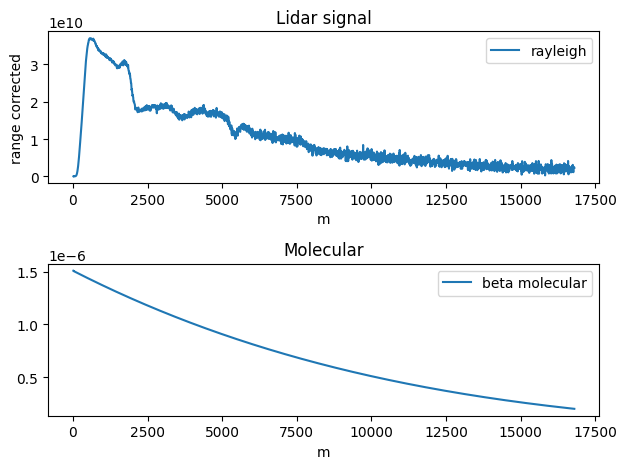

In [18]:
plt.subplot(2,1,1)
plt.plot(ref['z'], ref['rayleigh_signal'], label='rayleigh')
plt.title('Lidar signal')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('range corrected')
plt.xlabel('m')

plt.subplot(2,1,2)
plt.plot(ref['z'], ref_klett['molecular'], label='beta molecular')
plt.title('Molecular')
plt.legend(loc='upper right')
#plt.ylabel('')
plt.xlabel('m')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()



### Calcula backscatter

In [19]:
import lifa.processing.elastic_retrievals as el
rc_signal = ref['rayleigh_signal']
molecular_reference = ref_klett['molecular']

backscatter_output = el.klett_backscatter_aerosol(range_corrected_signal=rc_signal,
                                                       lidar_ratio_aerosol=50,
                                                       beta_molecular=molecular_reference,
                                                       index_reference=1338,
                                                       reference_range=134,
                                                       beta_aerosol_reference=3E-8,
                                                       bin_length=7.47146)

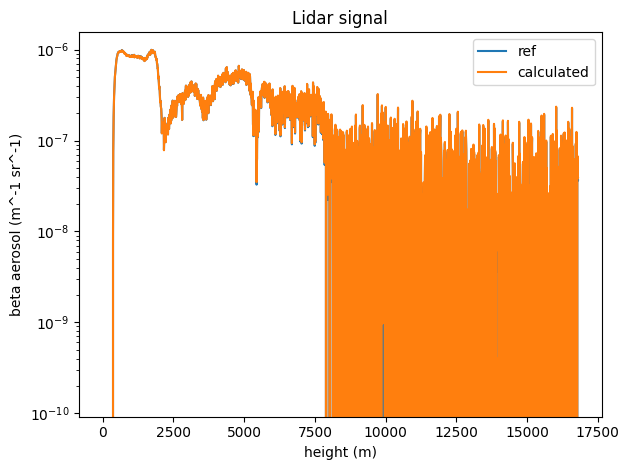

In [20]:
plt.subplot(1,1,1)
plt.plot(ref_klett['z'], ref_klett['backscatter'], label='ref')
plt.plot(ref_klett['z'], backscatter_output, label='calculated')
plt.title('Lidar signal')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylabel('beta aerosol (m^-1 sr^-1)')
plt.xlabel('height (m)')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

## Raman

Obtem o extinction rate do aerosol a partir do sinal Raman do N2. Ele assume uma concentração homogenea e conhecida de N2 na atmosfera, e utiliza isso para calcular o sinal Raman teórico. Ao comparar esse sinal teórico com o medido é possível estimar o extinction rate para o elástico.